## Classification of Hand Gestures

In this notebook, we train and evaluate different classification models for the task of hand gesture classification. We use the data generated in the previous notebook.

### Setup

---

To reload custom scripts automatically:

In [1]:
%load_ext autoreload
%autoreload 2

Define dependencies:

In [2]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import pandas as pd
from scipy import signal

# Modelling
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV


import os
import pickle
from tqdm import tqdm
import random
import sys
sys.path.insert(0, '../')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from src import utils

Define global variables:

In [3]:
DATA_ROOT = os.path.join("..", "data")
NINAPRO_ROOT = os.path.join("..", "data", "ninapro")
SAMPLING_EMG_RATE = 100

### Load the data preprocessed in the previous notebook

---

Before loading the data, make sure you downloaded them ([link](https://drive.google.com/file/d/1tz8tb6rruNvnlBkwDc80aT7D8jAXvwkF/view?usp=sharing)) and placed them into the data folder! 

We start by loading the data preprocessed in the previous notebook.

In [4]:
with open(os.path.join(DATA_ROOT, "exercise_1_processed.pkl"), 'rb') as file:
    subjects_features = pickle.load(file)

print("✅ Successfully loaded data, there are {} subjects.".format(len(subjects_features)))

✅ Successfully loaded data, there are 27 subjects.


Now, let's check what we get for instance for first subject:

In [5]:
# Get the data for the first subject
X_train, y_train, X_val, y_val, X_test, y_test = subjects_features[1]

# Print the shapes of the data
print(f"ℹ️ Number of windows: {X_train.shape[0]} (train), {X_val.shape[0]} (val), {X_test.shape[0]} (test)")
print(f"ℹ️ All have {X_train.shape[1]} features.")

ℹ️ Number of windows: 2006 (train), 1238 (val), 776 (test)
ℹ️ All have 100 features.


### Train and Eval the Models - train and eval on the same subject

---

In this section, we try to train and then evaluate the model on the data from 10 subjects. Note that these subjeocts will remain same for training as well as validation. We will train separate models for each subject and then evaluate them on the test data of the same subject.

In [6]:
# Select randmly 10 subjects
selected_subjects = random.sample(list(subjects_features.keys()), 10)

# Collect the data for the selected subjects
selected = dict()
for subject in selected_subjects:
    # Get the data for the subject
    X_train, y_train, X_val, y_val, X_test, y_test = subjects_features[subject]

    # Shuffle the data
    X_train, y_train = shuffle(X_train, y_train, random_state=42)

    # Add the data to the dictionary
    selected[subject] = (X_train, y_train, X_val, y_val, X_test, y_test)

Next, we define our models to be trained:

In [7]:
# Logistic regression optimised via SGD 
lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic regression', SGDClassifier(loss="log_loss", penalty="l2", max_iter=100, warm_start=False))
])

# SVM with RBF kernel
svc = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', C=1, gamma=1e-4))
])

# K nearest neighbours
knn = Pipeline([
    ('scaler', StandardScaler()), 
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

# Random forest
rf = Pipeline([
    ('scaler', StandardScaler()),  
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=10, warm_start=False))
])


# Collect the models in a dictionary
models = {
    "Logistic regression": lr,
    "SVM": svc,
    "KNN": knn,
    "Random forest": rf,
}

Now, train each model and evaluate it on validation data:

In [8]:
# Define the dictionary to store the results
results = dict()

for model_name, model in models.items():

    # Define the dictionary to store the results
    results[model_name] = dict()

    for subject in selected.keys():

        # Get the data for training and evaluation
        X_train, y_train, X_val, y_val, _, _ = selected[subject]

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model on training and validation data
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        # Compute the accuracy
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)

        # Store the results
        results[model_name][subject] = {
            "train_pred": y_train_pred,
            "train_acc": train_acc,
            "val_pred": y_val_pred,
            "val_acc": val_acc
        }

        # Compute the feature importance for logistic regression
        if model_name == "Logistic regression":
            # Compute the feature importance
            r = permutation_importance(model, X_val, y_val, n_repeats=30, random_state=42, scoring="accuracy")

            # Store the results
            results[model_name][subject]["importances_mean"] = r.importances_mean
            results[model_name][subject]["importances_std"] = r.importances_std
    
    # Compute the mean and std of the results
    train_acc = np.array([results[model_name][subject]["train_acc"] for subject in selected.keys()])
    val_acc = np.array([results[model_name][subject]["val_acc"] for subject in selected.keys()])

    train_mean, train_std = train_acc.mean(), train_acc.std()
    val_mean, val_std = val_acc.mean(), val_acc.std()

    # Print the 95 % confidence interval
    traincf = 1.96 * train_std / np.sqrt(len(selected.keys()))
    valcf = 1.96 * val_std / np.sqrt(len(selected.keys()))
    print(f"🤖 {model_name}:")
    print(f"ℹ️ Train: {train_mean:.3f} ± {traincf:.3f}")
    print(f"🚨 Val: {val_mean:.3f} ± {valcf:.3f}\n")


🤖 Logistic regression:
ℹ️ Train: 0.851 ± 0.030
🚨 Val: 0.713 ± 0.037

🤖 SVM:
ℹ️ Train: 0.363 ± 0.048
🚨 Val: 0.351 ± 0.051

🤖 KNN:
ℹ️ Train: 0.836 ± 0.011
🚨 Val: 0.616 ± 0.040

🤖 Random forest:
ℹ️ Train: 0.989 ± 0.004
🚨 Val: 0.766 ± 0.043



Now, let's collect the results into a dataframe:

In [9]:
results_df = pd.DataFrame(columns=["model", "subject", "train_acc", "val_acc"])

for model_name, model in models.items():
    for subject in selected.keys():
        train_acc = results[model_name][subject]["train_acc"]
        val_acc = results[model_name][subject]["val_acc"]

        new_row = pd.DataFrame({
            "model": model_name,
            "subject": subject,
            "train_acc": train_acc,
            "val_acc": val_acc
        }, columns=["model", "subject", "train_acc", "val_acc"], index=[0])

        results_df = pd.concat([results_df, new_row], ignore_index=True)

results_df.sort_values(by=["val_acc"], inplace=False, ascending=False).head(10)

,model,subject,train_acc,val_acc
32,Random forest,21,0.990802,0.883756
31,Random forest,8,0.996472,0.850974
1,Logistic regression,8,0.917843,0.812024
2,Logistic regression,21,0.915900,0.800298
30,Random forest,24,0.984072,0.784884
36,Random forest,12,0.995508,0.779639
38,Random forest,23,0.976528,0.779101
35,Random forest,22,0.987840,0.777975
0,Logistic regression,24,0.904434,0.772529
39,Random forest,20,0.992975,0.755663


Some models definitely look promising! Clearly many of them overfit the data which is a matter of adjusting the regularization parameters. We will do that later. For now, let's dive into the details of evaluation of feauture importances. For that, we will use permutation importance [more details](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance). In simple terms, for given number of times `K`, we shuffle the value of a feature and then evaluate the model's performance. In our case, we use accuracy. The difference between the original accuracy and the accuracy after shuffling the feature is the importance of that feature. We do this for all the features. Finally, we average the importance of each feature over `K` iterations. This gives us the final importance of each feature. 

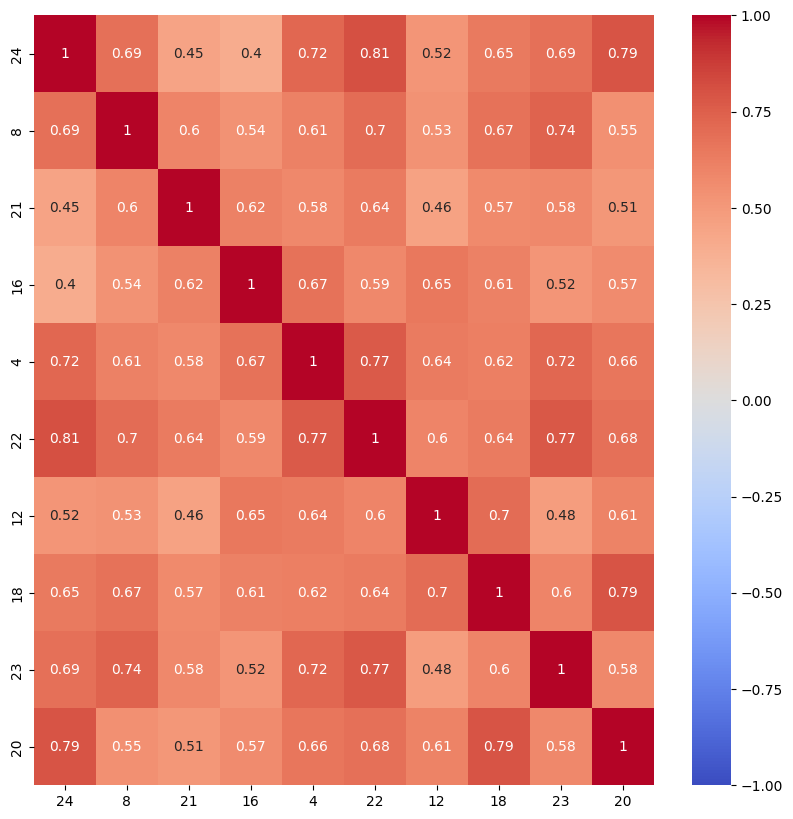

In [10]:
# Collect feature importances for all subjects
importances = dict()
for subject in selected.keys():
    importances[subject] = results["Logistic regression"][subject]["importances_mean"]

# Turn the dictionary into a dataframe
importances_df = pd.DataFrame(importances)
assert importances_df.shape[1] == 10, "❌ There should be 10 subjects."
assert importances_df.shape[0] == 100, "❌ There should be 100 features."

# Compute correlation matrix accross subjects
corr = importances_df.corr()

# Plot the correlation matrix using seaborn
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax, vmin=-1, vmax=1);

Now, let's plot the feature importances for each model using heatmap:

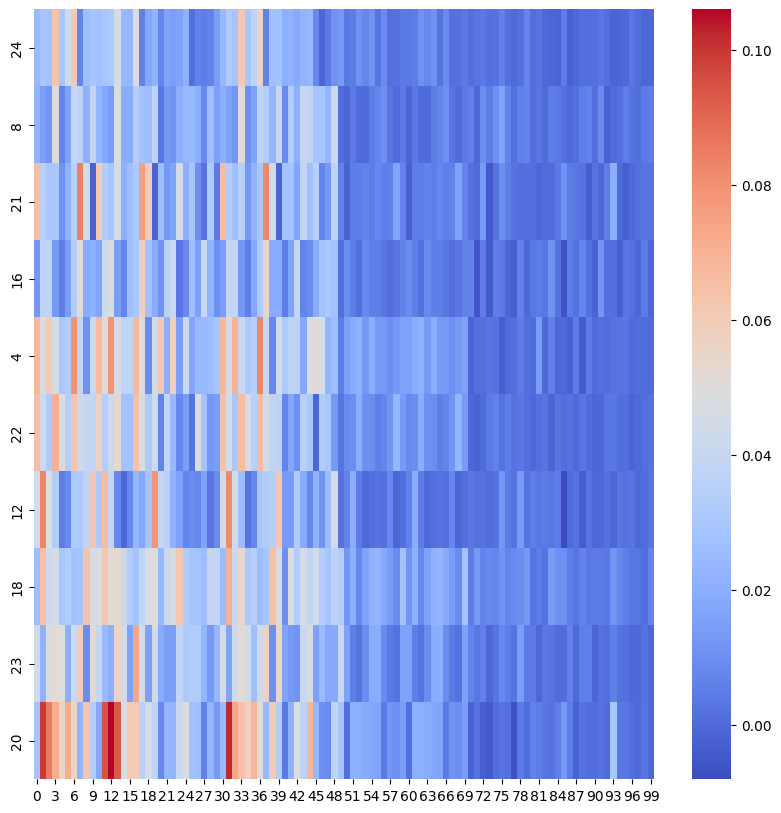

In [11]:
# Setup the figure
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data=importances_df.T, cmap="coolwarm", ax=ax);

We can see that in general, first 50 features are most important accross all the subjects. Finally, we will use grid search to find the best hyperparameters for the model. Let's start by defining the models and hyper-parameters to grid search over:

In [12]:
# Define models
pipelines = {
    "lr" : Pipeline([
        ('scaler', StandardScaler()),
        ('lr', SGDClassifier())
    ]),
    "knn" : Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ]),
    "rf" : Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier())
    ])
}

# Define hyperparameters
hyperparameters = {
    "lr" : {
        "lr__loss" : ["log", "hinge"],
        "lr__penalty" : ["l1", "l2"],
        "lr__alpha" : [0.0001, 0.001, 0.01, 0.1],
        "lr__max_iter" : [100, 200, 300, 400, 500]
    },
    "knn" : {
        "knn__n_neighbors" : [1, 3, 5, 7, 9, 11, 13, 15],
        "knn__weights" : ["uniform", "distance"],
        "knn__metric" : ["euclidean", "manhattan"]
    },
    "rf" : {
        "rf__n_estimators" : [100, 200, 300, 400, 500],
        "rf__max_depth" : [1, 3, 5, 7, 9, 11, 13, 15],
        "rf__max_features" : ["auto", "sqrt", "log2"]
    }
}

Next, run the hyper-parameter tuning:

In [18]:
path = os.path.join(DATA_ROOT, "hyptun_analysis_p1.pkl")

# Load the finetuning results
if os.path.exists(path):
    with open(path, "rb") as f:
        results_tuning = pickle.load(f)
        selected_ids = list(set([k[0] for k in results_tuning.keys()]))
        selected = dict()
        for subject in selected_ids:
             selected[subject] = subjects_features[subject]

# Run the finetuning - takes around one hour
else:
    # Define the dictionary to store the results
    results_tuning = dict()

    # Loop over the models
    for subject in tqdm(selected.keys()):

        # Get the data for training and evaluation
        X_train, y_train, X_val, y_val, _, _ = selected[subject]

        # Concat the training and validation data
        X = np.concatenate([X_train, X_val], axis=0)
        y = np.concatenate([y_train, y_val], axis=0)

        # Shuffle the data
        X, y = shuffle(X, y, random_state=42)

        for name, pipeline in pipelines.items():

            # Grid search
            grid_search = GridSearchCV(pipeline, hyperparameters[name], cv=5, scoring='accuracy', n_jobs=6)
            grid_search.fit(X, y)

            # Store the results
            results_tuning[(subject, name)] = {
                "best_params": grid_search.best_params_,
                "best_score": grid_search.best_score_,
                "best_estimator": grid_search.best_estimator_
            }

    # Save the results 
    with open(path, "wb") as f:
        pickle.dump(results_tuning, f)

Next, for each subject, select the best model, and compute the train, val and test accuracy:

In [19]:
# Store the results for each split
splits_results = {"train": [] , "val": [] , "test": []}

for subject in selected.keys():

    # Get the best model for the given subject
    best_score = 0
    best_model = None
    for name in pipelines.keys():
        score = results_tuning[(subject, name)]["best_score"]
        if score > best_score:
            best_score = score
            best_model = results_tuning[(subject, name)]["best_estimator"]
    
    # Get the data for training and evaluation
    X_train, y_train, X_val, y_val, X_test, y_test = selected[subject]

    # Compute the accuracy on all datasets
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Store the results
    splits_results["train"].append(train_acc)
    splits_results["val"].append(val_acc)
    splits_results["test"].append(test_acc)

# Compute the mean and std of the results
train_acc = np.array(splits_results["train"])
val_acc = np.array(splits_results["val"])
test_acc = np.array(splits_results["test"])

train_mean, train_std = train_acc.mean(), train_acc.std()
val_mean, val_std = val_acc.mean(), val_acc.std()
test_mean, test_std = test_acc.mean(), test_acc.std()

# Print the 95 % confidence interval
traincf = 1.96 * train_std / np.sqrt(len(selected.keys()))
valcf = 1.96 * val_std / np.sqrt(len(selected.keys()))
testcf = 1.96 * test_std / np.sqrt(len(selected.keys()))

print(f"ℹ️ Train: {train_mean:.3f} ± {traincf:.3f}")
print(f"🚨 Val: {val_mean:.3f} ± {valcf:.3f}")
print(f"🚀 Test: {test_mean:.3f} ± {testcf:.3f}\n")


ℹ️ Train: 1.000 ± 0.000
🚨 Val: 1.000 ± 0.001
🚀 Test: 0.816 ± 0.037



It is important to note that train and val were merged into a single dataset since the grid search conducted cross-validation on the training data. But with the exhaustive grid search, we managed to improve the mean accuracy by `5 %` to `81 %`. Now, let's create a dataframe where in rows we will have the models and in columns will we have the cross validation accuracy and test accuracy:

In [28]:
model_results = {model_name: {"val_acc": [], "test_acc": []} for model_name in pipelines.keys()}

for subject, model_name in results_tuning.keys():

    # Get the tuning result
    restun = results_tuning[(subject, model_name)]

    # Get best score
    best_score = restun["best_score"]

    # Get the testing data
    _, _, _, _, X_test, y_test = selected[subject]

    # Get the predictions
    y_test_pred = restun["best_estimator"].predict(X_test)

    # Compute the accuracy
    test_acc = accuracy_score(y_test, y_test_pred)

    # Store the results
    model_results[model_name]["val_acc"].append(best_score)
    model_results[model_name]["test_acc"].append(test_acc)

# Compute the mean and std of the results
df_tune_results = pd.DataFrame(columns=["model", "val_acc", "valcf", "test_acc", "testcf"])
for model_name in pipelines.keys():
    val_acc = np.array(model_results[model_name]["val_acc"])
    test_acc = np.array(model_results[model_name]["test_acc"])

    val_mean, val_std = val_acc.mean(), val_acc.std()
    test_mean, test_std = test_acc.mean(), test_acc.std()

    # Store the results
    new_row = pd.DataFrame({
        "model": model_name,
        "val_acc": val_mean,
        "valcf": 1.96 * val_std / np.sqrt(len(selected.keys())),
        "test_acc": test_mean,
        "testcf": 1.96 * test_std / np.sqrt(len(selected.keys())),
    }, columns=["model", "val_acc", "valcf", "test_acc", "testcf"], index=[0])

    df_tune_results = pd.concat([df_tune_results, new_row], ignore_index=True)

# Round the results to 3 decimal places
df_tune_results = df_tune_results.round(3)

# Sort the results by test accuracy
df_tune_results = df_tune_results.sort_values(by=["test_acc"], inplace=False, ascending=False).head(10)

# Save as latex table
df_tune_results.to_latex(os.path.join("..", "report", "tables", "hyptun_results.tex"), index=False)

### General Model Building

---

In this section, we select `K` number of subjects and train the model on the data from these subjects. Then, we evaluate the model on the data from the remaining subjects.